# Importando módulos 

In [1]:
import obspy
from obspy.taup import TauPyModel
from obspy.io.sac.sactrace import SACTrace

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
from obspy.signal.trigger import recursive_sta_lta

import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal
import subprocess
from sklearn import preprocessing

#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FixedLocator,StrMethodFormatter
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing
from shapely.geometry import MultiPoint

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import requests
import csv
import xml.etree.ElementTree as ET

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle


# Inputs e Outputs Directories

In [11]:
FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/'
MSEED_INPUT = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/DATA_GLIDER_2024/"
LOCAL_EVENTS_TABLE = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/event_files/terremotos_costa_SE.csv"
XML_FILE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/XML/glider_nettab_per_dive.xml'
QUAKEXML_FOLDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/'
METADATA_FILE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/data_glider_information_csv/metadados_glider_acustico_pmpas-bs.csv'
MODEL_CAKE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/EARTH_MODEL_AREA/model_ak135f_SOFAR.nd'
RSBR_STATIONS = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/STA_COORD/estacoes_RSBR_costa.txt'


#FOLDER_OUTPUT = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/'
#MSEED_INPUT = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/DATA/"
#METADATA_FILE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/data_glider_information_csv/metadados_glider_acustico_pmpas-bs.csv'
#QUAKEXML_FOLDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS/'
#MODEL_CAKE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'
#SBR_STATIONS = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/STA_COORD/estacoes_RSBR_costa.txt'
#LOCAL_EVENTS_TABLE = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/TERREMOTOS_SISBRA_2022/sisbra_costa.csv"

# Extraindo informações dos arquivos ".mseed"

In [4]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/GL.*'))

In [5]:
len(filenames_MSEED)

1639

In [6]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]

    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[-1].stats.endtime.datetime
    
    df = pd.DataFrame([[filename],[starttime],[endtime]], index=['filename','starttime','endtime']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [7]:
pandas_mseed_lst = []

with Pool(processes=4) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|███████████████████████████████████████| 1639/1639 [03:30<00:00,  7.78it/s]


In [8]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)

In [9]:
dataframe_mseed_final['starttime'] = pd.to_datetime(dataframe_mseed_final.starttime)
dataframe_mseed_final['endtime'] = pd.to_datetime(dataframe_mseed_final.endtime)
dataframe_mseed_final['date'] = pd.to_datetime(dataframe_mseed_final.starttime).dt.date
dataframe_mseed_final.sort_values('date')

,filename,starttime,endtime,date
8,GL.G1500..HHH.D.2015.316,2015-11-12 13:48:41,2015-11-12 23:59:59.990,2015-11-12
2,GL.G1500..HHH.D.2015.317,2015-11-13 00:00:00,2015-11-13 23:48:28.930,2015-11-13
0,GL.G1500..HHH.D.2015.318,2015-11-14 01:22:11,2015-11-14 22:36:02.930,2015-11-14
1,GL.G1500..HHH.D.2015.319,2015-11-15 00:00:18,2015-11-15 21:44:28.930,2015-11-15
5,GL.G1500..HHH.D.2015.320,2015-11-16 00:11:21,2015-11-16 21:54:52.930,2015-11-16
...,...,...,...,...
1634,GL.G211E..HHH.D.2021.304,2021-10-31 00:18:55,2021-10-31 14:31:12.270,2021-10-31
1635,GL.G211E..HHH.D.2021.305,2021-11-01 05:11:58,2021-11-01 13:30:59.780,2021-11-01
1637,GL.G211E..HHH.D.2021.306,2021-11-02 02:20:51,2021-11-02 15:18:01.010,2021-11-02
1636,GL.G211E..HHH.D.2021.307,2021-11-03 03:38:04,2021-11-03 11:50:10.980,2021-11-03


# Extraindo informações do Inventório ".CSV"

In [12]:
dataframe_glider_xml = pd.read_csv(METADATA_FILE)

In [13]:
dataframe_glider_xml['time'] = pd.to_datetime(dataframe_glider_xml.time)

In [14]:
dataframe_glider_xml = dataframe_glider_xml.rename(columns={"latitude": "lat", "longitude": "lon", "depth": "dep"})

In [15]:
dataframe_glider_xml

,time,filename,lat,lon,dep
0,2015-11-12 13:48:40.999995,pa0001au_001_151112_134841_rms_spl3.mat,-23.825157,-42.495483,1.314286
1,2015-11-12 13:49:41.000001,pa0001au_001_151112_134841_rms_spl3.mat,-23.824950,-42.495487,7.415555
2,2015-11-12 13:50:40.999998,pa0001au_002_151112_135041_rms_spl3.mat,-23.824745,-42.495490,15.776000
3,2015-11-12 13:51:41.000004,pa0001au_002_151112_135041_rms_spl3.mat,-23.824540,-42.495495,24.372000
4,2015-11-12 13:52:41.000001,pa0001au_003_151112_135241_rms_spl3.mat,-23.824331,-42.495500,32.912000
...,...,...,...,...,...
547748,2021-11-04 06:52:38.000000,pa0296au_011_211104_064338_rms_spl3.mat,-24.461742,-42.471264,866.012900
547749,2021-11-04 06:53:37.999997,pa0296au_012_211104_065338_rms_spl3.mat,-24.461819,-42.471302,873.586100
547750,2021-11-04 06:54:38.000003,pa0296au_012_211104_065338_rms_spl3.mat,-24.461980,-42.471510,879.579600
547751,2021-11-04 06:55:38.000000,pa0296au_012_211104_065338_rms_spl3.mat,-24.462152,-42.471740,884.380700


# Extraindo informações do Inventório de eventos costeiros

In [16]:
events = pd.read_csv(LOCAL_EVENTS_TABLE,sep=',')

print("Found %s event(s)" % len(events))

Found 145 event(s)


In [17]:
events

,year,mm,dd,hh,min,ss.s,L,latit,longit,depth,err(km),mag,tm,CAT,Io,Area,ST,Localities,(source) comments
0,2020,12,21,21,8,43.0,NaN,-15.99,-38.31,0,10,3.1,1,I,NaN,NaN,BA,Belmonte,(RSBR)
1,2016,9,18,14,26,9.0,NaN,-16.54,-37.95,0,20,2.9,1,I,NaN,NaN,BA,-,(UnB)
2,2018,1,25,1,27,20.0,NaN,-17.06,-38.86,0,15,3.1,1,I,NaN,NaN,BA,Prado,(RSBR-USP)
3,2021,3,3,3,35,13.0,NaN,-16.88,-37.90,0,31,3.6,1,I,NaN,NaN,BA,Plataforma Continental,(USP)
4,2021,3,3,3,43,22.0,NaN,-16.88,-37.92,0,31,3.2,1,I,NaN,NaN,BA,Plataforma Continental,(USP)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2022,7,11,0,55,29.0,NaN,-25.32,-42.85,0,30,3.2,1,I,NaN,NaN,SP,Plat. Continental,(USP)
141,2022,7,19,0,25,20.0,NaN,-25.36,-43.12,0,63,3.2,1,I,NaN,NaN,PR,Margem Continental,(USP)
142,2023,1,1,0,24,39.0,NaN,-25.36,-46.61,0,10,2.6,1,I,NaN,NaN,SP,Plataf.Continental,(RSBR-USP) IAG_DataBase
143,1996,1,13,0,33,9.0,NaN,-28.04,-46.38,0,50,3.2,1,I,NaN,NaN,SC,Margem Cont.,(IAG;IPT;COPEL;UFRS)


In [18]:
# Use isna() and loc[] for filtering
#filtered_data = events.loc[(events['year'].notna()) & (events['mm'].notna()) & (events['dd'].notna()) & (events['hh'].notna()) & (events['min'].notna()) & (events['ss.s'].notna())]
filtered_data = events.loc[(events['year'].notna()) & (events['mm'].notna()) & (events['dd'].notna()) & (events['hh'].notna()) & (events['min'].notna()) & (events['ss.s'].notna()) & (events['latit'].notna()) & (events['longit'].notna())]

In [19]:
filtered_data['time'] = filtered_data.apply(lambda row: UTCDateTime(row['year'],row['mm'],row['dd'],row['hh'],row['min'],row['ss.s']), axis=1)

/tmp/ipykernel_101447/3863700414.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = filtered_data.apply(lambda row: UTCDateTime(row['year'],row['mm'],row['dd'],row['hh'],row['min'],row['ss.s']), axis=1)


In [20]:
events = filtered_data

# RSBR SE COAST stations:

In [21]:
RSBR_LOC = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='str')
kstnm = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='str',usecols=1)
stla = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='float',usecols=2)
stlo = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='float',usecols=3)
stel = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='float',usecols=4)

/tmp/ipykernel_101447/1329273719.py:81: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax, [inset_x - inset_size / 2,


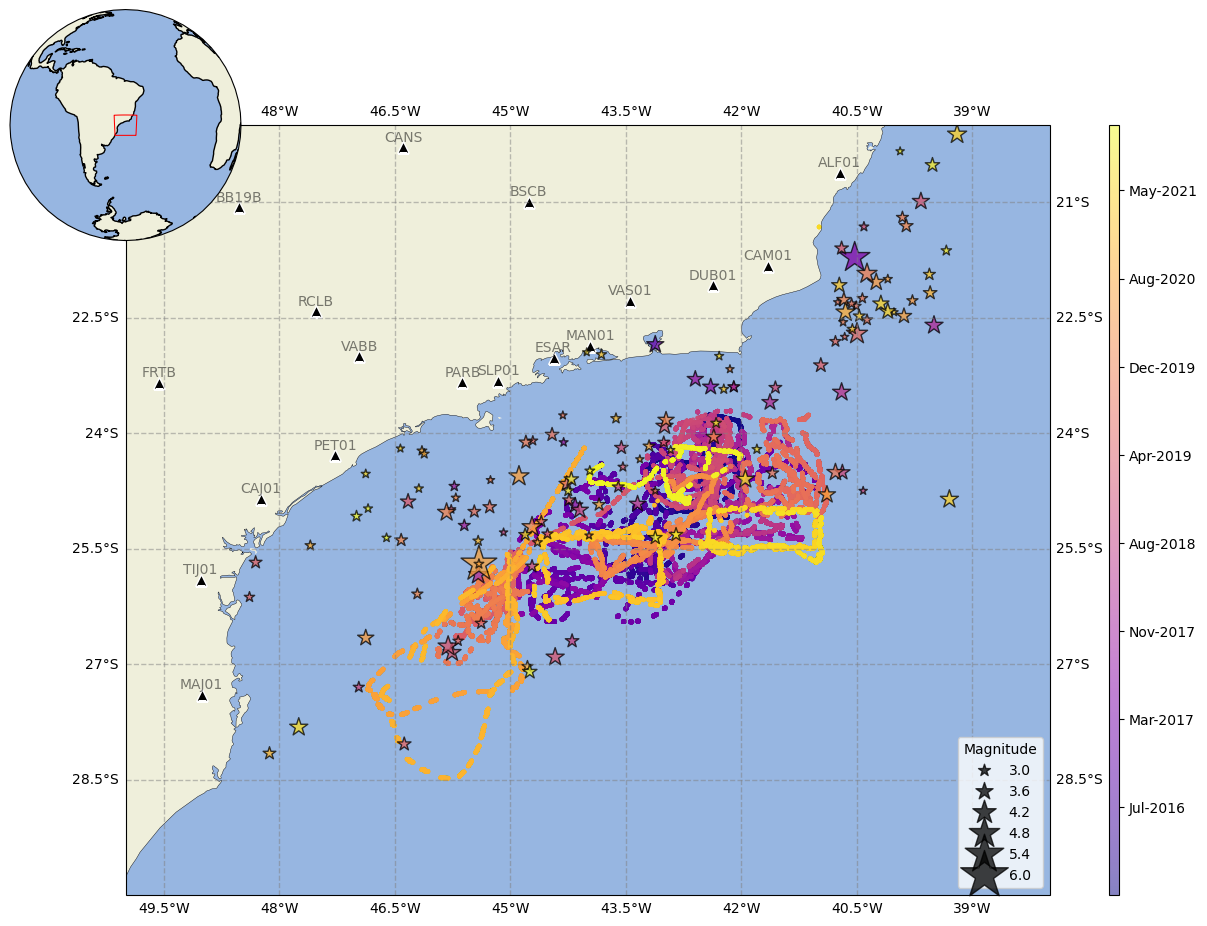

In [22]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(20,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-38

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon glider values

h = ax.scatter(dataframe_glider_xml['lon'],dataframe_glider_xml['lat'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['time']]),marker='.',alpha=0.5,cmap='plasma',s=20,transform=proj,label='Year')
# ----------------------------------------------------------------------------------------------------------
ax.scatter(stlo,stla,c='k',marker='^',ec='w',s=70,transform=proj)

# Use the cartopy interface to create a matplotlib transform object
# for the Geodetic coordinate system. We will use this along with
# matplotlib's offset_copy function to define a coordinate system which
# translates the text by 25 pixels to the left.
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', x=0,y=10)

for lo,la,name in zip(stlo,stla,kstnm):
    if lo < lonmax and lo > lonmin and la > latmin and la < latmax:
        ax.text(lo,la,s=name, verticalalignment='center', horizontalalignment='center',alpha=0.5,transform=text_transform)
  
# ----------------------------------------------------------------------------------------------------------

# Ploting lat/lon glider events
e = ax.scatter(events['longit'],events['latit'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in events['time']]),marker='*',alpha=0.75,cmap='plasma',edgecolor='k',s=events['mag']**4,transform=proj)
# ----------------------------------------------------------------------------------------------------------

# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# produce a legend with a cross-section of sizes from the scatter
kw_s = dict(prop="sizes", num=6, fmt="{x:.1f}",
          func=lambda s: s**(1/4))
legend1 = ax.legend(*e.legend_elements(**kw_s),
                    loc="lower right", title="Magnitude")

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

#####################################################
# Adding inset axes LEFT
#####################################################

# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.3
# Adding Geoaxes
ax_map = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax_map.set_global()

# Adding background map 
ax_map.add_feature(cfeature.LAND)
ax_map.add_feature(cfeature.OCEAN)
ax_map.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax_map.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax_map.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)

# LOOKING FOR EVENTs

In [23]:
dataframe_mseed_final

,filename,starttime,endtime,date
0,GL.G1500..HHH.D.2015.318,2015-11-14 01:22:11,2015-11-14 22:36:02.930,2015-11-14
1,GL.G1500..HHH.D.2015.319,2015-11-15 00:00:18,2015-11-15 21:44:28.930,2015-11-15
2,GL.G1500..HHH.D.2015.317,2015-11-13 00:00:00,2015-11-13 23:48:28.930,2015-11-13
3,GL.G1500..HHH.D.2015.322,2015-11-18 00:00:00,2015-11-18 23:59:59.990,2015-11-18
4,GL.G1500..HHH.D.2015.321,2015-11-17 00:24:51,2015-11-17 23:59:59.990,2015-11-17
...,...,...,...,...
1634,GL.G211E..HHH.D.2021.304,2021-10-31 00:18:55,2021-10-31 14:31:12.270,2021-10-31
1635,GL.G211E..HHH.D.2021.305,2021-11-01 05:11:58,2021-11-01 13:30:59.780,2021-11-01
1636,GL.G211E..HHH.D.2021.307,2021-11-03 03:38:04,2021-11-03 11:50:10.980,2021-11-03
1637,GL.G211E..HHH.D.2021.306,2021-11-02 02:20:51,2021-11-02 15:18:01.010,2021-11-02


In [24]:
def nearest_date(collum,pivot):
    '''
    To find a closest date
    '''
    min_id = (collum - pivot).abs().idxmin()

    return min_id

In [25]:
# Função de filtro para a condição especificada
def condition(lst):
    valid_last_elements = [True, False]
    return (lst[0] == False and 
            lst[1] == False and 
            lst[2] == False and 
            (lst[3] in valid_last_elements and lst[4] == True or lst[3] == True and lst[4] in valid_last_elements))

In [26]:
def event_search(inpt,CUT_BEFORE=-120,CUT_AFTER=300,FREQ_CFT=3,STA_short=2,LTA_short=30,THRON=3,THROFF=1.5,SNR_MIN=1.5,event_cut_sta_lta_band=30,nl_start=8,nl_end=22,sl_start=7,sl_end=7,time_sta_lta_ls=10,model_earth='ak135'):
        '''
        Function to search and plot events
        
        CUT_BEFORE:
        CUT_AFTER:,
        FREQ_CFT:,
        STA_short:,
        LTA_short,
        THRON:,
        event_cut_sta_lta_band:,
        nl_start:, 
        nl_end:,
        sl_start:,
        sl_end:,
        model_earth:
        ''' 

        ev_file = inpt[0]
        seismic_phase = inpt[1]
    
        # =========================================
        # CODE
        
        # Setting: Global font size
        mpl.rcParams.update({'font.size': 12})

        # -------------------------------------------------------------------------------------
        # Event catalog (https://docs.obspy.org/packages/autogen/obspy.core.event.Catalog.html)
        # -------------------------------------------------------------------------------------

        ev = ev_file
        
        ev_time = ev_file['time']
        ev_lat = ev_file.latit
        ev_long = ev_file.longit
        ev_depth = ev_file.depth

        if ev_depth == 0:
            ev_depth = 10
            ev_mag =  ev_file.mag
            
        # ###################################################################################################### #
        # ###################################################################################################### #
        # ###################################################################################################### #   
        # Initial stage: Is there an mseed file available for event time window (until 1 hour after event time)? #
        # ###################################################################################################### #    
        # ###################################################################################################### #   
        # ###################################################################################################### #
        
        ev_time_d = pd.to_datetime(ev_time.datetime) # To ensure that a value is a datetime object in pandas
        ev_time_final = ev_time+pd.Timedelta(hours=1)

        # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Location information: Is there location data for the glider on the selected event time window (until 1 hour after event time)?
        # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

        inv_glider_day = dataframe_glider_xml[(dataframe_glider_xml['time'] >= ev_time_d) & (dataframe_glider_xml['time'] <= (ev_time_d+pd.Timedelta(hours=1)))]

        if len(inv_glider_day) > 1:
                #yes

                lat_glider = inv_glider_day.lat.values.mean()
                lon_glider = inv_glider_day.lon.values.mean()
                dep_glider = -abs(inv_glider_day.dep.values.mean())
                time_glider = inv_glider_day.time.values[int(len(inv_glider_day)/2)]

                # -----------------------------------------------------------------
                # Estimation: distance, azimuth and backazimuth (https://docs.obspy.org/packages/autogen/obspy.geodetics.base.gps2dist_azimuth.html)

                dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,lat_glider,lon_glider)
                gcarc = obspy.geodetics.kilometer2degrees(dist/1000)

                # -----------------------------------------------------------------
                # Estimation: arrival time by CAKE (https://pyrocko.org/docs/current/apps/cake/index.html)
                # Cake is a command line tool contained in Pyrocko, which can solve some classical seismic ray theory problems for 1D layered earth models (layer cake models).
                    
                command = 'cake arrivals --model='+MODEL_CAKE+' --sdepth='+str(ev_depth)+' --rdepth='+str(np.abs(dep_glider)/1000)+' --distances='+str(dist/1000)+" --phases='p(seafloor)p'"
                proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
                (out, err) = proc.communicate()
                results = out.splitlines()

                # ############################################################################ #
                # Cake: expected result for first arrival (P, PKIKP, PKP):
                    
                # slow    dist  time   take inci effi spre phase             used
                # s/km    km    s      deg  deg  %    %
                # ----------------------------------------------------------------------------
                # 0.09711 10.00 2.3147  128 10.6 58.7  103 p                 (p)
                # ############################################################################ #

                # Is there an arrival time for this specific seismic phase?
                if len(results) > 3:
                    # yes

                    event = ev_time+float(results[3].split(' ')[2])
                    event = pd.to_datetime(event.datetime)
    
                    P_label = seismic_phase
                        
                    # #################################################################################################### #
                    # #################################################################################################### #
                    # #################################################################################################### #   
                    # Refine stage: Is there an mseed file available for event time window (ev_time + phase arrival time)? #
                    # #################################################################################################### #    
                    # #################################################################################################### #   
                    # #################################################################################################### #   

                    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                    # Location information: Is there location data for the glider on the selected event time window (ev_time + phase arrival time)?
                    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
            
                    inv_glider_day = dataframe_glider_xml.loc[(pd.to_datetime(dataframe_glider_xml['time'])-event).abs().idxmin()]
                    
                    # ++++++++++++++++++++++++++++ #
                    # ++++++++++++++++++++++++++++ #
                    # Refine: Compute new distance #
                    # ++++++++++++++++++++++++++++ #
                    # ++++++++++++++++++++++++++++ #
            
                    lat_glider = inv_glider_day.lat
                    lon_glider = inv_glider_day.lon
                    dep_glider = -abs(inv_glider_day.dep)
                    time_glider = inv_glider_day.time
    
                    # ----------------------------------------------------------------------------------------------------------------------------------
                    # Estimation: distance, azimuth and backazimuth (https://docs.obspy.org/packages/autogen/obspy.geodetics.base.gps2dist_azimuth.html)
    
                    dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,lat_glider,lon_glider)
                    gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
                    
                    # ++++++++++++++++++++++++++++++++++++++ #
                    # ++++++++++++++++++++++++++++++++++++++ #
                    # Refine: Compute new phase arrival time #
                    # ++++++++++++++++++++++++++++++++++++++ #
                    # ++++++++++++++++++++++++++++++++++++++ #
                    
                    # -------------------------------------------------------------------------------------------------------------------------------------------------------------
                    # Estimation: arrival time by CAKE (https://pyrocko.org/docs/current/apps/cake/index.html)
                    # Cake is a command line tool contained in Pyrocko, which can solve some classical seismic ray theory problems for 1D layered earth models (layer cake models).
                        
                    command = 'cake arrivals --model='+MODEL_CAKE+' --sdepth='+str(ev_depth)+' --rdepth='+str(np.abs(dep_glider)/1000)+' --distances='+str(dist/1000)+" --phases='p(seafloor)p,s(seafloor)p,s(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^P\\'"

                    proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
                    (out, err) = proc.communicate()
                    results = out.splitlines()

                    # ++++++++++++++++++++++++++++++ #
                    # ++++++++++++++++++++++++++++++ #
                    # Refine: Compute new event time #
                    # ++++++++++++++++++++++++++++++ #
                    # ++++++++++++++++++++++++++++++ #
                    
                    if len(results) > 3:
                        # yes
                        
                        event = ev_time+float(results[3].split(' ')[2])
                        eventS = ev_time+float(results[4].split(' ')[2])
                        eventT = ev_time+float(results[5].split(' ')[2])

                        file_mseed_event = dataframe_mseed_final[(dataframe_mseed_final.date == ev_time_d.date())]

                        if len(file_mseed_event) > 0:
                            
                            name_glider = file_mseed_event['filename'].tolist()[0].split('.')[1]

                            ev_file_mseed = file_mseed_event['filename'].tolist()[0]
                            file_mseed_ev = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/'+ev_file_mseed+'*'))[0]

                            # Cut all traces of this Stream object to given start (event date+CUT_BEFORE) and end time (event date+CUT_AFTER).
                            stream_mseed = read(file_mseed_ev,starttime=event+CUT_BEFORE,endtime=event+CUT_AFTER)
                            stream_mseed.merge(method=1,fill_value='interpolate')
                            
                            # +++++++++++++++ #
                            # +++++++++++++++ #
                            # Event detection #
                            # +++++++++++++++ #
                            # +++++++++++++++ #
                        
                            # Cut all traces of this Stream object around first wave arrival (event date-event_cut_sta_lta_band) and end time (event date+event_cut_sta_lta_band).
                            stream_mseed_around_P_wave_arrival = stream_mseed.copy()

                            if len(stream_mseed_around_P_wave_arrival.trim(event-event_cut_sta_lta_band,event+event_cut_sta_lta_band)) > 0:
                                # yes
                                
                                # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
                                # Plotting glider location: Is there a glider data (location) available (until 1 hour before and after event time)? 
                                # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
  
                                name_glider_df_sel = dataframe_glider_xml[(dataframe_glider_xml.time >= pd.to_datetime(event.datetime)-pd.Timedelta(hours=1)) & (dataframe_glider_xml.time <= pd.to_datetime(event.datetime)+pd.Timedelta(hours=1))]
                                
                                if len(name_glider_df_sel) > 0:
                                    # yes
                                    lat_event_info = name_glider_df_sel.lat.to_list() 
                                    lon_event_info = name_glider_df_sel.lon.to_list()          
                                    depth_event_info = [-abs(i) for i in name_glider_df_sel.dep.to_list()]       
                                    time_event_info = [i for i in name_glider_df_sel.time.to_list()]  

                                    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                                    # Saving: sac file trace (starttime: event+CUT_BEFORE & endtime: event+CUT_AFTER)
                                    
                                    headerHHH = {
                                                'kstnm': name_glider, 'kcmpnm': 'HHH','knetwk':'GL',
                                                'stla': float(lat_glider), 'stlo': float(lon_glider),'stel': float(dep_glider),
                                                'evdp': float(ev_depth), 'evla': float(ev_lat), 'evlo': float(ev_long), 'mag': float(ev_mag),
                                                'nzhour': int(stream_mseed[0].stats.starttime.hour),'nzjday': int(stream_mseed[0].stats.starttime.julday), 'nzmin': int(stream_mseed[0].stats.starttime.minute), 'nzmsec': int('{:03}'.format(stream_mseed[0].stats.starttime.microsecond)[:3]),'nzsec': int(stream_mseed[0].stats.starttime.second),'nzyear': int(stream_mseed[0].stats.starttime.year),
                                                'cmpaz': 0.0, 'cmpinc': 0.0, 'dist': float(dist/1000), 'gcarc': float(gcarc), 'az': float(az), 'baz': float(baz),
                                                'o':float(results[3].split(' ')[2]),'delta':stream_mseed[0].stats.delta
                                                }
                                    
                                    sacHHH = SACTrace(data=stream_mseed[0].data, **headerHHH)
        
                                    # Creating glider output directory:
                                    output_sac_data = FOLDER_OUTPUT+'EVENTS_GLIDERS/'+'GL'+'/'+name_glider+'/'+'{:04}'.format(ev_time.year)+'/'+'{:03}'.format(ev_time.julday)+'/'+'{:04}'.format(ev_time.year)+'.'+'{:03}'.format(ev_time.julday)+'.'+'{:02}'.format(ev_time.hour)+'.'+'{:02}'.format(ev_time.minute)+'.'+'{:02}'.format(ev_time.second)+'.'+'{:02}'.format(ev_time.microsecond)[:3]+'/'
                                    os.makedirs(output_sac_data,exist_ok=True)
                                    sacHHH.write(output_sac_data+'GL'+'.'+name_glider+'.'+'{:04}'.format(ev_time.year)+'.'+'{:03}'.format(ev_time.julday)+'.'+'{:02}'.format(ev_time.hour)+'.'+'{:02}'.format(ev_time.minute)+'.'+'{:02}'.format(ev_time.second)+'.'+'{:02}'.format(ev_time.microsecond)[:3]+'.H')
                                    
                                    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

                                    # Analysing the event (plotting and estimating parameters) 
                                    
                                    # ----------------------------------------------------------------------------------------------------------
                                    # set up the plot and create a GeoAxes:
                                    # ----------------------------------------------------------------------------------------------------------
    
                                    proj = ccrs.PlateCarree()
        
                                    fig = plt.figure(constrained_layout=True,figsize=(20,15))
                                    
                                    spec2 = gridspec.GridSpec(ncols=3, nrows=9, figure=fig)
                                    ax = fig.add_subplot(spec2[0:3,:], projection=proj)
                                    ax1 = fig.add_subplot(spec2[3:6,0])
                                    ax2 = fig.add_subplot(spec2[6:9,0],sharex=ax1)
        
                                    # ----------------------------------------------------------------------------------------------------------
                                    # Limit the extent of the map to a small longitude/latitude range (Southeast Brazil region)
                                    # ----------------------------------------------------------------------------------------------------------
        
                                    latmin=-28.5
                                    latmax=-22.5
                                    lonmin=-50
                                    lonmax=-40
        
                                    ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())
        
                                    # ---------------------------------------------------------------------------------------------------------------------------------------------------
                                    # Plotting latitude, longitude, and depth (glider's trajectory, glider location, and coastal stations) [https://scitools.org.uk/cartopy/docs/latest/]
                                    # ---------------------------------------------------------------------------------------------------------------------------------------------------
        
                                    h = ax.scatter(dataframe_glider_xml['lon'],dataframe_glider_xml['lat'],c=np.array([mdates.date2num(i) for i in dataframe_glider_xml['time']]),marker='o',alpha=0.5,cmap='plasma',s=25,transform=proj)
                                    ax.scatter(lon_glider, lat_glider, color='r',marker='o',s=100,ec='k',transform=proj)
        
                                    ax.scatter(stlo,stla,c='k',marker='^',ec='w',s=70,transform=proj)
                
                                    # Ploting lat/lon glider events
                                    ax.scatter(ev_long,ev_lat,c='r',marker='*',edgecolor='k',s=ev_mag**5,transform=proj)
                                    
                                    # ----------------------------------------------------------------------------------------------------------

                                    # Use the Cartopy interface to create a Matplotlib transform object
                                    # for the Geodetic coordinate system. We will use this along with
                                    # Matplotlib's offset_copy function to define a coordinate system
                                    # that translates the text 10 pixels upward.
                                    
                                    geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
                                    text_transform = offset_copy(geodetic_transform, units='dots', x=0,y=10)
                                    
                                    # Add text 10 pixels upward.
                                    for lo,la,name in zip(stlo,stla,kstnm):
                                        if lo < lonmax and lo > lonmin and la > latmin and la < latmax:
                                            ax.text(lo,la,s=name, verticalalignment='center', horizontalalignment='center',alpha=0.5,transform=text_transform)
                                    
                                    # ---------------------
                                    # Adding background map 
                                    
                                    ax.add_feature(cfeature.LAND)
                                    ax.add_feature(cfeature.OCEAN)
                                    ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
                                    ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                                    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
        
                                    # Title
                                    ax.set_title(ev_time.strftime('%Y-%m-%dT%H:%M:%S')+'\n Dist: '+str(round(dist/1000))+' km'+' Dep: '+str(round(ev_depth))+' km'+'\n Mag: '+str(ev_mag)+' mR'+'\n ',y=1.02,fontsize=20)
        
                                    # ----------------
                                    # Adding colorbar
        
                                    divider = make_axes_locatable(ax)
                                    ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)
        
                                    fig.add_axes(ax_cb)
                                    cb = plt.colorbar(h, cax=ax_cb)
                                    cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
        
                                    # ================================
                                    # Adding inset: LATITUDE-LONGITUDE
                                    # ================================
        
                                    axins = plt.axes([0.8, 0.70, 0.15, 0.15],projection=proj)
                                    axins.scatter(lon_event_info,lat_event_info,c=np.array([mdates.date2num(i) for i in time_event_info]),marker='o',cmap='plasma',s=100,transform=proj,vmax=max([mdates.date2num(i) for i in dataframe_glider_xml['time']]),vmin=min([mdates.date2num(i) for i in dataframe_glider_xml['time']]))
                                    axins.scatter(lon_glider, lat_glider, color="none",marker='o',s=100,ec='k',lw=2,transform=proj)
                                    axins.set_title("Lat: "+str(round(lat_glider,2))+'$^\circ$ | '+"Lon: "+str(round(lon_glider,2))+'$^\circ$',fontsize=13)

                                    # ---------------------
                                    # Adding background map 
                                    
                                    axins.add_feature(cfeature.LAND)
                                    axins.add_feature(cfeature.OCEAN)
                                    axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
                                    axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
        
                                    # ----------------------------------------------------------------------------------------------------------
                                    # Adding grid
        
                                    axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                                    axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

                                    # --------------------------------
                                    # subregion of the original image 
                                    
                                    x1 = np.min(lon_event_info)-abs(np.min(lon_event_info)/90)
                                    x2 = np.max(lon_event_info)+abs(np.max(lon_event_info)/90)
                                    y1 = np.min(lat_event_info)-abs(np.min(lat_event_info)/90)
                                    y2 = np.max(lat_event_info)+abs(np.max(lat_event_info)/90)
                                    axins.set_xlim(x1, x2)
                                    axins.set_ylim(y1, y2)
                                    ax.indicate_inset_zoom(axins, edgecolor="black")
        
                                    # =============================
                                    # Adding inset: DEPTH-LONGITUDE
                                    # =============================
        
                                    ax_histx = plt.axes([0.8, 0.86, 0.15, 0.05],sharex=axins,facecolor='lightsteelblue')
                                    ax_histx.scatter(lon_event_info,depth_event_info, c=np.array(mdates.date2num(time_event_info)),marker='o',vmax=max([mdates.date2num(i) for i in dataframe_mseed_final['starttime']]),vmin=min([mdates.date2num(i) for i in dataframe_mseed_final['starttime']]),alpha=0.5,cmap='plasma',s=100)
                                    ax_histx.scatter(lon_glider,dep_glider, c="none",marker='o',ec='k',lw=2,s=100)
                                    ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                                    ax_histx.set_title("Depth: "+str(round(dep_glider))+' m',fontsize=13)
                                    ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
                                    ax_histx.set_ylim(-1000,0)
                                    ax_histx.yaxis.set_major_formatter('{x} m')
                                    ax_histx.yaxis.set_major_locator(MultipleLocator(500))
                                    ax_histx.yaxis.set_minor_locator(MultipleLocator(100))
        
                                    # ==========================
                                    # Adding global location map
                                    # ==========================
                                    
                                    # --------------
                                    # Adding Geoaxes
                                    
                                    ax_map = plt.axes([0.25, 0.85, 0.13, 0.13], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
                                    ax_map.set_global()

                                    # ---------------------
                                    # Adding background map 

                                    ax_map.add_feature(cfeature.LAND)
                                    ax_map.add_feature(cfeature.OCEAN)
                                    ax_map.add_feature(cfeature.COASTLINE)

                                    # -----------------------------
                                    # Adding red rectangle position
                                    
                                    nvert = 100
                                    lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                                         np.linspace(lonmin, lonmax, nvert),
                                                         np.linspace(lonmax, lonmax, nvert)].tolist()
                                    lats = np.r_[np.linspace(latmin, latmax, nvert),
                                                         np.linspace(latmax, latmax, nvert),
                                                         np.linspace(latmax, latmin, nvert)].tolist()
        
                                    ring = LinearRing(list(zip(lons, lats)))
                                    
                                    # ------------------------------------------------------------------
                                    # Plotting: rectangle position and event-station (path and location)
                                    
                                    ax_map.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)
                                    ax_map.scatter(ev_long,ev_lat,color="y",marker='*',s=200,ec='k',transform=ccrs.PlateCarree())
                                    ax_map.scatter(np.mean(lon_event_info),np.mean(lat_event_info),color="r",marker='^',s=50,transform=ccrs.PlateCarree())
                                    ax_map.plot([np.mean(lon_event_info), ev_long], [np.mean(lat_event_info), ev_lat], c='gray',ls='-',lw=2, transform=ccrs.Geodetic())
        
                                    # ===========================================================================================
                                    # Adding a trace plot (high (st_HF) and low (st_LF) frequency filtered data in the same axes)
                                    # ===========================================================================================

                                    # -----------------
                                    # Duplicating axes:
                                    
                                    ax1_HF = ax1.twinx()

                                    # ---------------------
                                    # Retrieving trace data
        
                                    st_LF = stream_mseed.copy()
                                    st_HF = stream_mseed.copy()

                                    # ---------------------------------------------------
                                    # Computing & Plotting: High frequency lowpassed data
                                    
                                    for tr in st_HF:
                                        tr.detrend("linear")
                                        tr.taper(max_percentage=0.05, type='cosine')
                                        tr.filter('highpass', freq=FREQ_CFT, corners=4, zerophase=True)
                                        line_HF, = ax1_HF.plot(tr.times('matplotlib'), tr.data,'grey', lw=2,alpha=0.5,label='> '+str(FREQ_CFT)+' Hz')
                                    ax1_HF.legend(handles=[line_HF],loc='lower right', fontsize=10, edgecolor='grey', labelcolor='grey')   

                                    # --------------------------------------------------
                                    # Computing & Plotting: Low frequency lowpassed data
                                    
                                    for tr in st_LF:
                                        tr.detrend("linear")
                                        tr.taper(max_percentage=0.05, type='cosine')
                                        tr.filter('lowpass', freq=FREQ_CFT, corners=4, zerophase=True)
                                        line_LF, = ax1.plot(tr.times('matplotlib'), tr.data,'k', lw=1, label='< '+str(FREQ_CFT)+' Hz')
                                    ax1.legend(handles=[line_LF],loc='lower left', fontsize=10, edgecolor='k', labelcolor='k')

                                    # ---------------------------------------------
                                    # Plotting: First wave arrival (line and label)
                                    
                                    ax1.text(x=event.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s=P_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax1.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')

                                    ax1.text(x=eventS.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s='S',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax1.axvline(x=eventS.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                                    
                                    ax1.text(x=eventT.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s='T',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax1.axvline(x=eventT.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')

                                    # -------------------------
                                    # Plotting: axes parameters 
                                    
                                    ax1.set_ylabel('Amplitude [units]')
                                    ax1.set_ylim(-1.5*abs(np.max(st_LF[0].data)),1.5*abs(np.max(st_LF[0].data)))
                                    ax1.set_xlim(st_LF[0].times('matplotlib')[0],st_LF[0].times('matplotlib')[-1])
                                    
                                    # DateLocator: interval 2 min
                                    locator = mdates.MinuteLocator(interval=2)
                                    ax1.xaxis.set_major_locator(locator)
                                    locatormin = mdates.MinuteLocator(interval=1)
                                    ax1.xaxis.set_minor_locator(locatormin)
                                    
                                    # DateFormatter: interval 2 min
                                    formatter = mdates.DateFormatter('%H:%M:%S')
                                    ax1.xaxis.set_major_formatter(formatter)
                    
                                    ax1.set_title('Station: '+name_glider)
        
                                    ax1_HF.set_ylim(-1.5*abs(np.max(st_HF[0].data)),1.5*abs(np.max(st_HF[0].data)))
                                    ax1_HF.set_xlim(st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1])
                                
                                    ax1.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=False,labelbottom=False, labeltop=False, labelleft=True, labelright=False)
                                    ax1_HF.tick_params(axis='both',which="both",bottom=False, top=False, left=False, right=True,labelbottom=False, labeltop=False, labelleft=False, labelright=True,labelcolor='grey')
     
                                    ax1.spines['top'].set_linewidth(2)
                                    ax1.spines['right'].set_linewidth(2)
                                    ax1.spines['bottom'].set_linewidth(2)
                                    ax1.spines['left'].set_linewidth(2)
                                    ax1.xaxis.set_tick_params(width=2)
                                    ax1.yaxis.set_tick_params(width=2)      
                                    
                                    # ============================================================================================================================================
                                    # Adding spectrogram plot [Power spectral density] (https://docs.scipy.org/doc/scipy-1.13.1/reference/generated/scipy.signal.spectrogram.html)
                                    # ============================================================================================================================================

                                    # -----------------------------------------------------------
                                    # Computing: Spectrogram with consecutive Fourier transforms 

                                    fs = stream_mseed[0].stats.sampling_rate  # Sampling rate (samples per second)
                                    signal_data = stream_mseed[0].data

                                    # ---------------------------------------------------------------------
                                    # Spectrogram (Power spectral ‘density’ where Sxx has units of V**2/Hz)
                                    
                                    frequencies, times, Sxx = signal.spectrogram(x=signal_data, fs=fs,nperseg=128,scaling='density')

                                    # -------------------------------------------------------------------------------------------------------------------
                                    # Plotting: Spectrogram (https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html)
                                    
                                    im = ax2.imshow(10 * np.log10(Sxx),extent=[st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1], 0, fs/2],aspect='auto',origin='lower',cmap='magma',interpolation='kaiser',vmin=50,vmax=150)

                                    # -------------------------
                                    # Plotting: axes parameters 

                                    ax2.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)
                                    ax2.xaxis.set_major_locator(locator)
                                    ax2.xaxis.set_minor_locator(locatormin)
                                    ax2.xaxis.set_major_formatter(formatter)
                                    ax2.spines['top'].set_linewidth(2)
                                    ax2.spines['right'].set_linewidth(2)
                                    ax2.spines['bottom'].set_linewidth(2)
                                    ax2.spines['left'].set_linewidth(2)
                                    ax2.xaxis.set_tick_params(width=2)
                                    ax2.yaxis.set_tick_params(width=2)  
                                    ax2.set_ylabel('Frequency [Hz]')

                                    # ---------------------------------------------
                                    # Plotting: First wave arrival (line and label)
                                                                        
                                    ax2.text(x=event.matplotlib_date,y=45,s=P_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax2.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
                                    
                                    ax2.text(x=eventS.matplotlib_date,y=45,s='S',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax2.axvline(x=eventS.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
                                            
                                    ax2.text(x=eventT.matplotlib_date,y=45,s='T',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax2.axvline(x=eventT.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
        
                                    # ----------------------------------------------------------------------------------------------
                                    # Plotting: Colorbar (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html)
        
                                    ax_cbar = inset_axes(ax2,
                                                                width="20%",  # width = 15% of parent_bbox width
                                                                height="3%",  # height : 3%
                                                                loc='upper right',
                                                                bbox_to_anchor=(-0.1, -0.1, 1, 1),
                                                                bbox_transform=ax2.transAxes,
                                                                borderpad=0.1
                                                                )

                                    cbar = fig.colorbar(im, cax=ax_cbar, orientation="horizontal")
                                    cbar.ax.xaxis.set_ticks_position('top')
                                    cbar.ax.xaxis.set_label_position('bottom')
                                    cbar.set_label('PSD (dB unit²/Hz)')
                                    cbar.outline.set_linewidth(2)
             
                                    # ===========================================================
                                    # Figure
                                    # ===========================================================
    
                                    filter_class = [['Raw Data'],[25,50],[10,25],[5,10],[2,5],[0.7,2]]
        
                                    mins2 = MultipleLocator(10)
                                    mins1 = MultipleLocator(5)
        
                                    check_SNR_STA_LTA = []                             
                                    srn_per_band_lst = []                             
                                    sta_lta_max_per_band_lst = []                             
                                    noise_per_band_lst = []
    
                                    for idx,freqs in enumerate(filter_class):
        
                                        axs1 = fig.add_subplot(spec2[3+idx,1]) 
                                    
                                        axs2 = fig.add_subplot(spec2[3+idx,2])
                                        
                                        st_full = stream_mseed.copy()
                                        st_full.trim(event-event_cut_sta_lta_band,event+event_cut_sta_lta_band)
                                        
                                        time_x_axis = st_full[0].times() - event_cut_sta_lta_band
                                        st_full[0].data = preprocessing.normalize([st_full[0].data])[0]
                                        
                                        # --------------
                                        # first axes
                                        
                                        if idx == 0:
                                            
                                            st_full.detrend("linear")
                                            st_full.taper(max_percentage=0.05, type='cosine')
                                            
                                            line_full, = axs1.plot(time_x_axis, st_full[0].data,'k', lw=0.5,label=freqs[0])
                                            axs1.legend(handles=[line_full],loc='upper left', fontsize=10, edgecolor='k', labelcolor='k')   
                                            axs1.axvline(x=0,ymin=0, ymax=1, color='k',lw=0.5,linestyle='--')
                                            axs1.set_xlim(-event_cut_sta_lta_band,event_cut_sta_lta_band)
                                            axs1.xaxis.set_major_locator(mins2)
                                            axs1.xaxis.set_minor_locator(mins1)
                                            axs1.set_title('Time relative to theoretical arrival (s)')
        
                                            # ----------------------------------------------------------------------------------------------------------
                                            # SNR P-wave
                                            # ----------------------------------------------------------------------------------------------------------

                                            # --------------------------------------------------------------------
                                            # Retrieving the P-wave normalized amplitude between -x and +x seconds

                                            amp_P = st_full[0].data[(event_cut_sta_lta_band-sl_start)*100:(event_cut_sta_lta_band+sl_end)*100]
                                            amp_P_time = st_full[0].times()[(event_cut_sta_lta_band-sl_start)*100:(event_cut_sta_lta_band+sl_end)*100] - event_cut_sta_lta_band
                                            
                                            # --------------------------------------------------------------------
                                            # Retrieving the noise normalized amplitude between -x and +x seconds
              
                                            noise_amp = st_full[0].data[(event_cut_sta_lta_band-nl_end)*100:(event_cut_sta_lta_band-nl_start)*100]
                                            noise_time = st_full[0].times()[(event_cut_sta_lta_band-nl_end)*100:(event_cut_sta_lta_band-nl_start)*100] - event_cut_sta_lta_band
        
                                            # ---------------
                                            # Evaluating: SNR
                                            
                                            powS = np.mean(np.abs(amp_P))
                                            powN = np.mean(np.abs(noise_amp))
                                            
                                            snr = powS/powN
                                            snr = round(snr,1)

                                            # -----------------------------
                                            # Evaluating: noise energy mean
                                            
                                            potencia_ruido = np.mean(noise_amp**2)
                                            
                                            # ----------------------------
                                            # Evaluating: Noise level (dB)
                                            
                                            nivel_ruido_db = 10 * np.log10(potencia_ruido)
   
                                            # -------------------------------------
                                            # Plotting: SNR, noise & signal windows

                                            axs1.text(x=0.99,y=0.95,s='SRN: '+str(snr),ha="right", va="top", transform=axs1.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            axs1.plot(amp_P_time, amp_P,'darkred', alpha=0.85,lw=1)
                                            axs1.plot(noise_time, noise_amp,'darkblue', alpha=0.85,lw=1)                                       
                                            axs1.text(x=0.01,y=0.05,s='Noise: '+str(round(nivel_ruido_db))+' dB',ha="left", va="bottom",transform=axs1.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
    
                                            # -------------------------
                                            # Plotting: axes parameters 
                                            
                                            axs1.spines['top'].set_linewidth(2)
                                            axs1.spines['right'].set_linewidth(2)
                                            axs1.spines['bottom'].set_linewidth(2)
                                            axs1.spines['left'].set_linewidth(2)
                                            axs1.xaxis.set_tick_params(width=2)
                                            axs1.yaxis.set_tick_params(width=2)                                
                                            
                                            # ----------------------------------------------------------------------------------------------------------                                   
                                            # STA/LTA curve
                                            # ----------------------------------------------------------------------------------------------------------
        
                                            st_cft = st_full.copy()
                    
                                            for tr in st_cft:
                                                tr.detrend("linear")
                                                tr.taper(max_percentage=0.05, type='cosine')
                                                tr.filter('lowpass', freq=FREQ_CFT, corners=4, zerophase=True)
                                            
                                            # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------                                           
                                            # Evaluating: Time & amplitude of the STA/LTA curve (https://docs.obspy.org/packages/autogen/obspy.signal.trigger.classic_sta_lta_py.html#obspy.signal.trigger.classic_sta_lta_py)
                                            
                                            cft = recursive_sta_lta(st_full[0].data, int((STA_short/2)*st_full[0].stats.sampling_rate), int((LTA_short/2)*st_full[0].stats.sampling_rate))
                                            
                                            # -----------------------------------------------------
                                            # Evaluating: Time & amplitude of the STA/LTA curve max

                                            # mask to desired boolean interval
                                            mask = (time_x_axis >= -time_sta_lta_ls) & (time_x_axis <= time_sta_lta_ls)
                                                                                        
                                            sta_lta_max_amp = cft[np.where(mask)[0][np.argmax(cft[mask])]]
                                            
                                            sta_lta_max_time = time_x_axis[np.where(mask)[0][np.argmax(cft[mask])]]
                                            
                                            # -----------------------------------------------------
                                            # Plotting: Time & amplitude of the STA/LTA curve max

                                            axs2.scatter(sta_lta_max_time,sta_lta_max_amp, edgecolors='orange',facecolors='None',marker='o',linewidths=1)
                                            
                                            # -------------------------------------------------
                                            # Evaluating: Time & amplitude of the First P-wave
     
                                            if sta_lta_max_amp >= THRON and snr >= SNR_MIN:
                                                for cl_index in range(np.where(mask)[0][np.argmax(cft[mask])] - 1, -1, -1):
                                                        if  THROFF > cft[cl_index]:
                                                            break
                                      
                                                index_first_THROFF = cl_index
                                                sta_lta_P_wave_time = time_x_axis[index_first_THROFF]
                                                sta_lta_P_wave_amp = st_full[0].data[index_first_THROFF]
                                                sta_lta_P_wave_amp_sta_lta = cft[index_first_THROFF]
                                                                                  
                                                # ------------------------------------------------
                                                # Evaluating: Time & amplitude of the First P-wave
                                                
                                                axs1.scatter(sta_lta_P_wave_time,sta_lta_P_wave_amp, edgecolors='r',facecolors='None',marker='o',linewidths=2,s=50,label='first arrival')
                                                axs2.scatter(sta_lta_P_wave_time,sta_lta_P_wave_amp_sta_lta, edgecolors='r',facecolors='None',marker='o',linewidths=2,s=50,label='first arrival')
                                                axs1.text(x=0.99,y=0.05,s='$t_r$:'+str(round(sta_lta_P_wave_time,1))+' s',ha="right", va="bottom", transform=axs1.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))

                                            # -----------------------------
                                            # Plotting: STA/LTA parameters

                                            axs2.text(x=0.99,y=0.95,s='max: '+str(round(sta_lta_max_amp,1)),ha="right", va="top",transform=axs2.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            axs2.text(x=0.99,y=0.05,s='THRON: '+str(THRON)+'\n'+'THROFF: '+str(THROFF),ha="right", va="bottom",transform=axs2.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            axs2.text(x=0.01,y=0.05,s='STA: '+str(STA_short)+'\n'+'LTA: '+str(LTA_short),ha="left", va="bottom",transform=axs2.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))

                                            # ----------------------------
                                            # Plotting: STA/LTA curve

                                            line_full, = axs2.plot(time_x_axis,cft, 'k',label=freqs[0])
                                            axs2.legend(handles=[line_full],loc='upper left', fontsize=10, edgecolor='k', labelcolor='k')   
                                            axs2.axvline(x=0,ymin=0, ymax=1, color='k',lw=0.5,linestyle='--')
                                            axs2.axhline(xmin=0,xmax=1, y=THROFF, color='orange',lw=0.5,linestyle='--')
                                            axs2.axhline(xmin=0,xmax=1, y=THRON, color='darkorange',lw=0.5,linestyle='--')
                                            
                                            # -------------------------
                                            # Plotting: axes parameters 
    
                                            axs2.set_xlim(-event_cut_sta_lta_band,event_cut_sta_lta_band)
                                            axs2.xaxis.set_major_locator(mins2)
                                            axs2.xaxis.set_minor_locator(mins1)
                                            axs2.set_title('Time relative to theoretical arrival (s)')
                                            axs2.set_ylim(0, 10)
                                            axs2.spines['top'].set_linewidth(2)
                                            axs2.spines['right'].set_linewidth(2)
                                            axs2.spines['bottom'].set_linewidth(2)
                                            axs2.spines['left'].set_linewidth(2)
                                            axs2.xaxis.set_tick_params(width=2)
                                            axs2.yaxis.set_tick_params(width=2)  


                                            axs1.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=False)
                                            axs2.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=False)

                                        # --------------
                                        # following axes
    
                                        if idx > 0:
                                            
                                            st_full.filter('bandpass', freqmin=freqs[0],freqmax=freqs[1], corners=4, zerophase=False)
                                            st_full.taper(max_percentage=0.05, type='cosine')                                    
                                        
                                            line_full, = axs1.plot(time_x_axis,st_full[0].data,'k', lw=0.5,label=str(freqs[0])+'-'+str(freqs[1])+' Hz')
                                            axs1.legend(handles=[line_full],loc='upper left', fontsize=10, edgecolor='k', labelcolor='k')   
                                            axs1.axvline(x=0,ymin=0, ymax=1, color='k',lw=0.5,linestyle='--')
                                            axs1.set_xlim(-event_cut_sta_lta_band,event_cut_sta_lta_band)
                                            axs1.xaxis.set_major_locator(mins2)
                                            axs1.xaxis.set_minor_locator(mins1)
        
                                            # ----------------------------------------------------------------------------------------------------------
                                            # SNR P-wave
                                            # ----------------------------------------------------------------------------------------------------------
                
                                            # --------------------------------------------------------------------
                                            # Retrieving the P-wave normalized amplitude between -x and +x seconds

                                            amp_P = st_full[0].data[(event_cut_sta_lta_band-sl_start)*100:(event_cut_sta_lta_band+sl_end)*100]
                                            amp_P_time = st_full[0].times()[(event_cut_sta_lta_band-sl_start)*100:(event_cut_sta_lta_band+sl_end)*100] - event_cut_sta_lta_band
               
                                            # -------------------------------------------------------------------
                                            # Retrieving the noise normalized amplitude between -x and +x seconds

                                            noise_amp = st_full[0].data[(event_cut_sta_lta_band-nl_end)*100:(event_cut_sta_lta_band-nl_start)*100]
                                            noise_time = st_full[0].times()[(event_cut_sta_lta_band-nl_end)*100:(event_cut_sta_lta_band-nl_start)*100] - event_cut_sta_lta_band
        
                                            # ---------------
                                            # Evaluating: SNR
                                            
                                            powS = np.mean(np.abs(amp_P))
                                            powN = np.mean(np.abs(noise_amp))
                                            
                                            snr = powS/powN
                                            snr = round(snr,1)
                                            # -----------------------------
                                            # Evaluating: noise energy mean
                                            
                                            potencia_ruido = np.mean(noise_amp**2)
                                            
                                            # ----------------------------
                                            # Evaluating: Noise level (dB)
                                            
                                            nivel_ruido_db = 10 * np.log10(potencia_ruido)
   
                                            # -------------------------------------
                                            # Plotting: SNR, noise & signal windows
                                            
                                            axs1.text(x=0.99,y=0.95,s='SRN: '+str(snr),ha="right", va="top", transform=axs1.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            axs1.plot(amp_P_time, amp_P,'darkred', alpha=0.85,lw=1)
                                            axs1.plot(noise_time, noise_amp,'darkblue', alpha=0.85, lw=1)                                 
                                            axs1.text(x=0.01,y=0.05,s='Noise: '+str(round(nivel_ruido_db))+' dB',ha="left", va="bottom",transform=axs1.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            
                                            axs1.spines['top'].set_linewidth(2)
                                            axs1.spines['right'].set_linewidth(2)
                                            axs1.spines['bottom'].set_linewidth(2)
                                            axs1.spines['left'].set_linewidth(2)
                                            axs1.xaxis.set_tick_params(width=2)
                                            axs1.yaxis.set_tick_params(width=2)  
        
                                            # ----------------------------------------------------------------------------------------------------------                                   
                                            # STA/LTA curve
                                            # ----------------------------------------------------------------------------------------------------------
              
                                            st_cft = st_full.copy()
                    
                                            for tr in st_cft:
                                                tr.detrend("linear")
                                                tr.taper(max_percentage=0.05, type='cosine')
                                                tr.filter('lowpass', freq=FREQ_CFT, corners=4, zerophase=True)
                                            
                                            # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------                                           
                                            # Evaluating: Time & amplitude of the STA/LTA curve (https://docs.obspy.org/packages/autogen/obspy.signal.trigger.classic_sta_lta_py.html#obspy.signal.trigger.classic_sta_lta_py)
                                            
                                            cft = recursive_sta_lta(st_full[0].data, int((STA_short/2)*st_full[0].stats.sampling_rate), int((LTA_short/2)*st_full[0].stats.sampling_rate))

                                            # -----------------------------------------------------
                                            # Evaluating: Time & amplitude of the STA/LTA curve max
  
                                            # mask to desired boolean interval
                                            mask = (time_x_axis >= -time_sta_lta_ls) & (time_x_axis <= time_sta_lta_ls)
                                                                                        
                                            sta_lta_max_amp = cft[np.where(mask)[0][np.argmax(cft[mask])]]
                                            
                                            sta_lta_max_time = time_x_axis[np.where(mask)[0][np.argmax(cft[mask])]]
                                            
                                            # -----------------------------------------------------
                                            # Plotting: Time & amplitude of the STA/LTA curve max

                                            axs2.scatter(sta_lta_max_time,sta_lta_max_amp, edgecolors='orange',facecolors='None',marker='o',linewidths=1)
                                            
                                            # -------------------------------------------------
                                            # Evaluating: Time & amplitude of the First P-wave
                                       
                                            if sta_lta_max_amp >= THRON and snr >= SNR_MIN:
                                                for cl_index in range(np.where(mask)[0][np.argmax(cft[mask])] - 1, -1, -1):
                                                        if  THROFF > cft[cl_index]:
                                                            break      
                                                            
                                                index_first_THROFF = cl_index
                                                sta_lta_P_wave_time = time_x_axis[index_first_THROFF]
                                                sta_lta_P_wave_amp = st_full[0].data[index_first_THROFF]
                                                sta_lta_P_wave_amp_sta_lta = cft[index_first_THROFF]
                                                       
                                                # ------------------------------------------------
                                                # Evaluating: Time & amplitude of the First P-wave
                                                
                                                axs1.scatter(sta_lta_P_wave_time,sta_lta_P_wave_amp, edgecolors='r',facecolors='None',marker='o',linewidths=2,s=50,label='first arrival')
                                                axs2.scatter(sta_lta_P_wave_time,sta_lta_P_wave_amp_sta_lta, edgecolors='r',facecolors='None',marker='o',linewidths=2,s=50,label='first arrival')
                                                axs1.text(x=0.99,y=0.05,s='$t_r$:'+str(round(sta_lta_P_wave_time,1))+' s',ha="right", va="bottom", transform=axs1.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))

                                            # -----------------------------
                                            # Plotting: STA/LTA parameters
                                            
                                            axs2.text(x=0.99,y=0.95,s='max: '+str(round(sta_lta_max_amp,1)),ha="right", va="top",transform=axs2.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            axs2.text(x=0.99,y=0.05,s='THRON: '+str(THRON)+'\n'+'THROFF: '+str(THROFF),ha="right", va="bottom",transform=axs2.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            axs2.text(x=0.01,y=0.05,s='STA: '+str(STA_short)+'\n'+'LTA: '+str(LTA_short),ha="left", va="bottom",transform=axs2.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))

                                            # ----------------------------
                                            # Plotting: STA/LTA curve

                                            line_full, = axs2.plot(time_x_axis,cft, 'k',label=str(freqs[0])+'-'+str(freqs[1])+' Hz')
                                            axs2.legend(handles=[line_full],loc='upper left', fontsize=10, edgecolor='k', labelcolor='k')  
                                            axs2.axhline(xmin=0,xmax=1, y=THRON, color='darkorange',lw=0.5,linestyle='--')
                                            axs2.axhline(xmin=0,xmax=1, y=THROFF, color='orange',lw=0.5,linestyle='--')
                                            axs2.axvline(x=0,ymin=0, ymax=1, color='k',lw=0.5,linestyle='--')
                                            
                                            # -------------------------
                                            # Plotting: axes parameters 
                                            
                                            axs2.set_xlim(-event_cut_sta_lta_band,event_cut_sta_lta_band)
                                            axs2.xaxis.set_major_locator(mins2)
                                            axs2.xaxis.set_minor_locator(mins1)
                                            axs2.set_ylim(0, 10)
                                            axs2.spines['top'].set_linewidth(2)
                                            axs2.spines['right'].set_linewidth(2)
                                            axs2.spines['bottom'].set_linewidth(2)
                                            axs2.spines['left'].set_linewidth(2)
                                            axs2.xaxis.set_tick_params(width=2)
                                            axs2.yaxis.set_tick_params(width=2)  
                                            
                                            axs1.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=False)
                                            axs2.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=False)

                                            # --------------
                                            # last axes
        
                                            if idx == 5:
                                                axs1.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=False)
                                                axs2.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=False)
                                                                                       
                                            # --------------------------------------------------------------------------------
                                            # Evaluating: automatic event detection according to SNR and STA/LTA amplitude values                                  

                                            if sta_lta_max_amp >= THRON and snr >= SNR_MIN:
                                                check_SNR_STA_LTA.append(True)                                             
                                                
                                            else:
                                                check_SNR_STA_LTA.append(False)
                                            
                                         
                                        srn_per_band_lst.append(snr)                             
                                        sta_lta_max_per_band_lst.append(sta_lta_max_amp)                            
                                        noise_per_band_lst.append(nivel_ruido_db)
                                    
                                    # -------------
                                    # Saving figure
                                    # -------------
                                    
                                    os.makedirs(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_LOCAL_SE/'+model_earth+'/'+P_label+'/',exist_ok=True)
                                    fig.savefig(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_LOCAL_SE/'+model_earth+'/'+P_label+'/event_mseed_detection_'+model_earth+'_'+P_label+'_'+ev_time.strftime('%Y_%m_%d_%H_%M_%S')+'_'+name_glider+'_mag_'+str(ev_mag)+'mR.png',pad_inches=0.02,dpi=100)
                             
                                   
                                    # ----------------
                                    # Saving dataframe
                                        
                                    df = pd.DataFrame([[ev_file_mseed],[name_glider],['P'],[ev_file['Localities']],[ev_time],[ev_lat],[ev_long],[ev_depth],[gcarc],[ev_mag],['mb'],[event],[time_glider],[lat_glider],[lon_glider],[dep_glider],[time_event_info],[lat_event_info],[lon_event_info],[depth_event_info],[srn_per_band_lst],[sta_lta_max_per_band_lst],[noise_per_band_lst],[True],[sta_lta_P_wave_time]], index=['filename_mseed','name_glider','Phase','ev_ID','ev_time','ev_lat','ev_long','ev_depth','distance','magnitude','magnitude_type','phases_time','time_glider','lat_glider','lon_glider','dep_glider','time_dive_info','lat_dive_info','lon_dive_info','depth_dive_info','srn_per_band','sta_lta_max_per_band','noise_per_band','automatic_event_detection','automatic_time_residual']).T
                                  
                                    # ----------------------------------------------------------------------------------------------------------
                                    # Close the figure after savig 
                                    # ----------------------------------------------------------------------------------------------------------                             
                                    
                                    plt.close('all')

In [27]:
fases_sismicas = ["P"]
input_data = []
for fs in fases_sismicas:
    for ev in events.iterrows():
        input_data.append([ev[1],fs])

In [28]:
df_results = []
with Pool(processes=1) as p:
    max_ = len(input_data)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(event_search,input_data):
            df_results.append(result)           
            pbar.update()

 38%|███████████████▉                          | 54/142 [00:21<00:03, 22.39it/s]/home/sysop/Programs/anaconda3/lib/python3.11/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
100%|█████████████████████████████████████████| 142/142 [00:37<00:00,  3.74it/s]
